# Load data

In [1]:
from datasets import load_dataset
import os

data_path = "../data/elaborations"

data_files_c2s = {
    'train': os.path.join(data_path,"train","train_ds_c2s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2s.csv")         
}

data_files_c4s = {
    'train': os.path.join(data_path,"train","train_ds_c4s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4s.csv")         
}

data_files_c2sp = {
    'train': os.path.join(data_path,"train","train_ds_c2sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2sp.csv")         
}


data_files_c2os = {
    'train': os.path.join(data_path,"train","train_ds_c2os.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2os.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2os.csv")         
}

data_files_c2osp = {
    'train': os.path.join(data_path,"train","train_ds_c2osp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2osp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2osp.csv")         
}

data_files_c4sp = {
    'train': os.path.join(data_path,"train","train_ds_c4sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4sp.csv")         
}


data_files_c4osp = {
    'train': os.path.join(data_path,"train","train_ds_c4osp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4osp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4osp.csv")         
}

dataset = load_dataset('csv', data_files=data_files_c2s)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 1046
    })
    validation: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 132
    })
    test: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 116
    })
})


## Check length

In [2]:
def count_texts_over_word_limit(dataset_dict, column, word_limit=512):
    word_count = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        count_over_limit = 0

        for example in dataset:
            try:
                num_words = len(example[column].split()) # count on spaces
                if num_words > word_limit:
                    count_over_limit += 1
            except AttributeError as e: 
                print(f"Empty string in doc num: {example['doc_num']}")
                continue 

        word_count[split] = count_over_limit

    return word_count

count_texts_over_word_limit(dataset, column='source_text', word_limit=50)

{'train': 0, 'validation': 0, 'test': 0}

# Load the model

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# LLAMA 3.2 3B
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-3B') #cache_dir="../models/llama/") 
model =  AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.2-3B', device_map ={'':torch.cuda.current_device()})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Config

In [3]:
# set the pad_token for llama 3.2 3B
tokenizer.pad_token = tokenizer.eos_token #"<|finetune_right_pad_id|>" 

# Tokenize dataset

In [4]:
import numpy as np

def adjust_labels(example):
    # replace padding token in labels with -100 for correct loss calculation
    example["labels"] = [
        -100 if token == tokenizer.pad_token_id else token
        for token in example["labels"]
    ]
    return example

def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['source_text'], truncation=True, padding="max_length",max_length=64) # padding="max_length"
    # labels
    labels = tokenizer(examples['elaboration_sentence'],truncation=True,padding="max_length", max_length=64)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids'] #labels['input_ids'] or np.array(labels['input_ids'])
    return inputs

tokenized_dataset = dataset.map(tokenize_func, batched=True)
#tokenized_dataset = tokenized_dataset.map(adjust_labels, batched=False)
#tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Fine-tune

In [5]:
from model_utils import calculate_logging_steps
steps_per_epoch, logging_steps = calculate_logging_steps(dataset, batch_size=32, logging_frequency=6)

Steps per epoch: 32
Logging steps: 5


## No instruct

In [6]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForLanguageModeling


model.train()

# data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False,  # no masked language modeling 
)

logs_dir = "../models/llama/llama3.2-news-ft/logs/logs-c2s"

training_args = SFTConfig(
    output_dir="../models/llama/llama3.2-news-ft/results/results-c2s",
    max_seq_length= 64,
    eval_strategy="epoch",  
    save_strategy="no",  
    logging_strategy="steps",  
    logging_steps=6, 
    learning_rate=1e-6,  
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    num_train_epochs=3,  
    weight_decay=0.01,  
    warmup_steps=2,  
    optim="paged_adamw_8bit",  
    fp16=True,  
    logging_dir=logs_dir, 
    push_to_hub=False,
    group_by_length=True,  
    save_total_limit=0,

)

trainer = SFTTrainer(
    model,
    train_dataset=tokenized_dataset["train"],  
    eval_dataset=tokenized_dataset["validation"],  
    args=training_args,   
    data_collator=data_collator, 
)

model.config.use_cache = False

In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.960200,3.143848
2,2.700500,3.052567
3,2.559600,3.032315


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=99, training_loss=2.8347623805807096, metrics={'train_runtime': 30.1256, 'train_samples_per_second': 104.164, 'train_steps_per_second': 3.286, 'total_flos': 3396568057380864.0, 'train_loss': 2.8347623805807096, 'epoch': 3.0})

### Learning curve

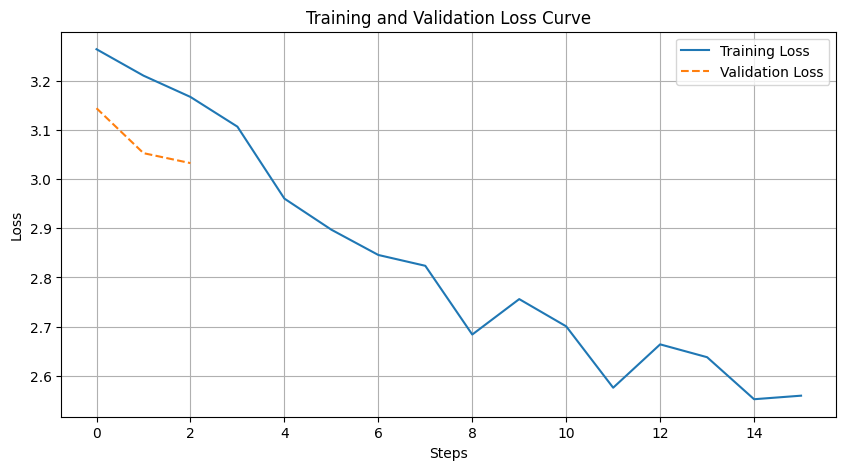

In [8]:
from model_utils import plot_loss_curves
plot_loss_curves(trainer)

## Instruct

### Learning curve

In [ ]:
from model_utils import plot_loss_curves
plot_loss_curves(trainer)

# Clean-up

In [73]:
from model_utils import clear_directory
import torch

torch.cuda.empty_cache()
del model, trainer, tokenizer, data_collator
clear_directory(logs_dir)

Cleared contents of: ../models/llama/llama3.2-news-ft/logs/logs-c2s
